In [1]:
!pip3 install gymnasium
# !pip install swig
# !pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 19.4 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from collections import deque
import random

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Working with {device}")

Working with cpu


In [3]:
class FCQV(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32, 32), activation_fc = nn.ReLU()):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], 1))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, state, action):
        x = state
        y = action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)

        z = torch.cat((x, y), dim = 1).to(device).to(torch.float32)

        return self.layers(z)

class FCDP(nn.Module):
    def __init__(self, input_dim, action_bounds, hidden_dims=(32, 32), activation_fc = nn.ReLU(), out_activation = nn.Tanh()):
        super(FCDP, self).__init__()
        self.env_min, self.env_max = torch.Tensor(action_bounds[0]).to(device), torch.Tensor(action_bounds[1]).to(device)
        self.activation_fc = activation_fc
        self.out_activation = out_activation
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], len(self.env_max)))
        self.layers.append(self.out_activation)
        self.layers = nn.Sequential(*self.layers)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        out= self.layers(x)

        return self.rescale(out)

    def rescale(self, out):
        return (out + 1)*(self.env_max - self.env_min) / (2) + self.env_min




In [4]:
class NormalNoiseDecayStrategy():
    def __init__(self, bounds, init_noise_ratio=0.4, min_noise_ratio=0.05, decay_steps=10000):
        self.t = 0
        self.low, self.high = bounds
        self.noise_ratio = init_noise_ratio
        self.init_noise_ratio = init_noise_ratio
        self.min_noise_ratio = min_noise_ratio
        self.decay_steps = decay_steps

    def _noise_ratio_update(self):
        noise_ratio = 1 - self.t / self.decay_steps
        noise_ratio = (self.init_noise_ratio - self.min_noise_ratio) * noise_ratio + self.min_noise_ratio
        noise_ratio = np.clip(noise_ratio, self.min_noise_ratio, self.init_noise_ratio)
        self.t += 1
        return noise_ratio

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.noise_ratio * self.high

        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)

        self.noise_ratio = self._noise_ratio_update()
        return action

In [5]:
class ReplayBuffer:
    def __init__(self, max_len):
        self.experiences = deque(maxlen = max_len)

    def add_experience(self, state, action, reward, next_state, is_terminal):
        self.experiences.append((state, action, reward, next_state, is_terminal))

    def get_batch_experince(self, batch_size):
        batch = random.sample(self.experiences, batch_size)
        states = np.array([i[0] for i in batch])
        actions = np.array([i[1] for i in batch])
        rewards = np.array([i[2] for i in batch])
        next_states = np.array([i[3] for i in batch])
        is_terminals = np.array([i[4] for i in batch])
        return (tuple([states, actions, rewards, next_states, is_terminals]))


In [28]:
class DDPG:
    def __init__(self, env, gamma, replay_buffer_size, batch_size, hidden_dims, policy_optimizer, value_optimizer, tau, update_steps, decay_steps, lr = (1e-4, 1e-4)):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.replaybuffer = ReplayBuffer(replay_buffer_size)
        self.batch_size = batch_size
        self.update_steps = update_steps
        self.decay_steps = decay_steps

        nS, nA = self.env.observation_space.shape[0], self.env.action_space.shape[0]
        action_bounds = self.env.action_space.low, self.env.action_space.high
        self.online_value_model = FCQV(nS + nA, hidden_dims[0]).to(device)
        self.target_value_model = FCQV(nS + nA, hidden_dims[0]).to(device)
        self.online_policy_model = FCDP(nS, action_bounds, hidden_dims[1]).to(device)
        self.target_policy_model = FCDP(nS, action_bounds, hidden_dims[1]).to(device)
        self.update_model(tau = 1.0)
        self.env.reset()

        self.value_optimizer = value_optimizer(self.online_value_model.parameters(), lr[0])
        self.policy_optimizer = policy_optimizer(self.online_policy_model.parameters(), lr[1])

        self.action_policy = NormalNoiseDecayStrategy(action_bounds, decay_steps = self.decay_steps)

        self.returns = deque(maxlen = 100)

    def update_model(self, tau = None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        states = torch.from_numpy(states).to(device)
        actions = torch.from_numpy(actions).to(device)
        next_states = torch.from_numpy(next_states).to(device)
        rewards = torch.from_numpy(rewards).to(device)
        is_terminals = torch.from_numpy(is_terminals).to(device)

        argmax_a_q_sp = self.target_policy_model(next_states)
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)


        q_sa = self.online_value_model(states, actions)
        td_error = q_sa - target_q_sa.detach()
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        argmax_a_q_s = self.online_policy_model(states)
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)
        policy_loss = -max_a_q_s.mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    def interactive_step(self, state):
        action = self.action_policy.select_action(self.target_policy_model, state)
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        self.replaybuffer.add_experience(state, action, reward, new_state, int(terminated and not truncated))
        return new_state, terminated or truncated

    def train(self, num_steps, step, evals, goal):
        epis = 1
        terminated = False
        state = self.env.reset()[0]
        for i in tqdm(range(1, num_steps + 1)):
            state, terminated = self.interactive_step(state)
            if(len(self.replaybuffer.experiences) > self.batch_size):
                self.optimize_model(self.replaybuffer.get_batch_experince(self.batch_size))
            if(terminated):
                epis += 1
                state = self.env.reset()[0]
                if(epis % step == 0):
                    if(self.evaluate(evals, goal)):
                        torch.save(self.target_policy_model.state_dict(), f'./{i/step}_iteration_target_policy.pth')
                        torch.save(self.target_value_model.state_dict(), f'./{i/step}_iteration_target_value.pth')
                        return
            if(num_steps % self.update_steps == 0):
                self.update_model()

    def evaluate(self, evals, goal):
        for _ in range(evals):
            state = self.env.reset()[0]
            terminated = False
            return_val = 0
            while(not terminated):
                # img = self.env.render()
                # cv2.imshow("Environment", img)
                # cv2.waitKey(1)
                action = self.target_policy_model(state).detach().cpu()
                state, reward, terminate, truncated, _ = self.env.step(action[0])
                terminated = truncated or terminate
                return_val += reward
            self.returns.append(return_val)

        # cv2.destroyAllWindows()
        _mean = np.mean(list(self.returns)[-evals:])
        print(f"\nMean return value of last {evals} evaluations = {_mean}")
        plt.plot(range(len(self.returns)), self.returns)
        plt.show()
        return (goal <= _mean)


  1%|          | 2795/400000 [00:20<44:08, 149.99it/s]


Mean return value of last 8 evaluations = -1722.573974609375


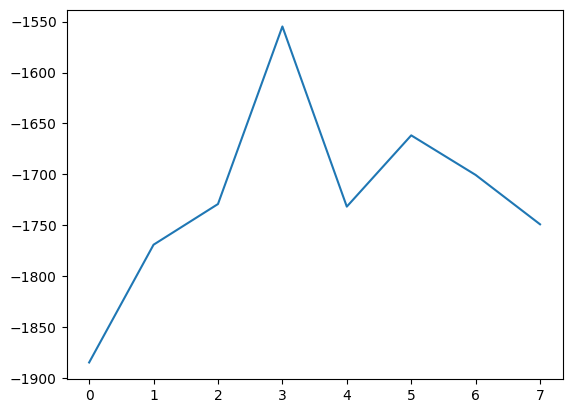

  1%|▏         | 5600/400000 [00:43<49:33, 132.66it/s]


Mean return value of last 8 evaluations = -1659.4010009765625


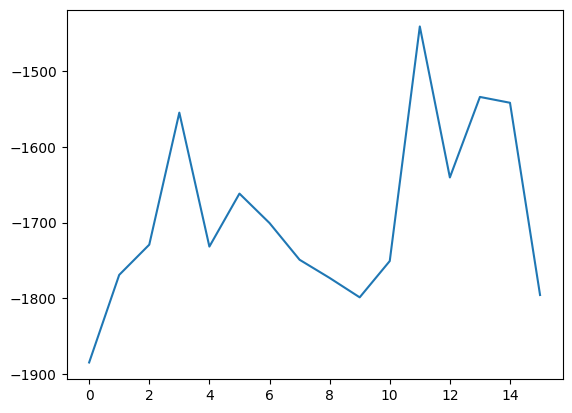

  2%|▏         | 8391/400000 [01:06<46:16, 141.04it/s]


Mean return value of last 8 evaluations = -1528.22705078125


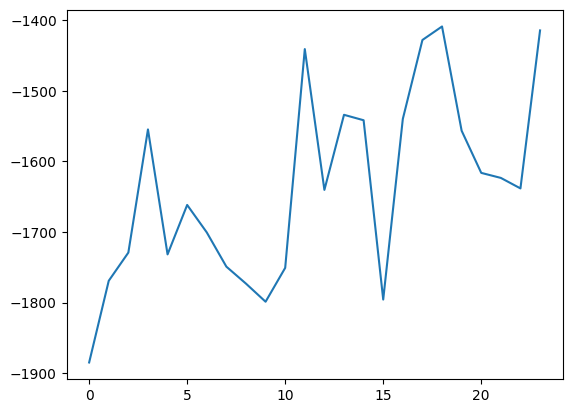

  3%|▎         | 11193/400000 [01:29<50:11, 129.12it/s]


Mean return value of last 8 evaluations = -1456.046142578125


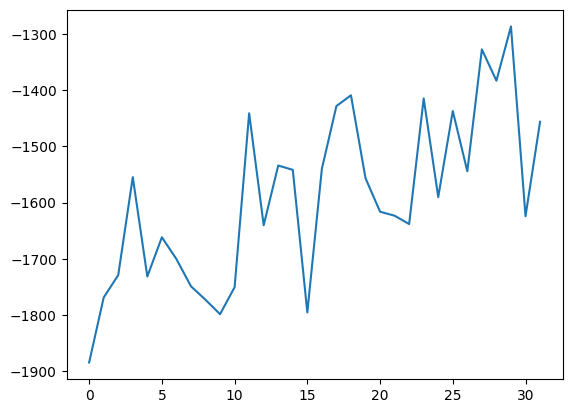

  3%|▎         | 13995/400000 [01:51<47:43, 134.82it/s]


Mean return value of last 8 evaluations = -1463.8065185546875


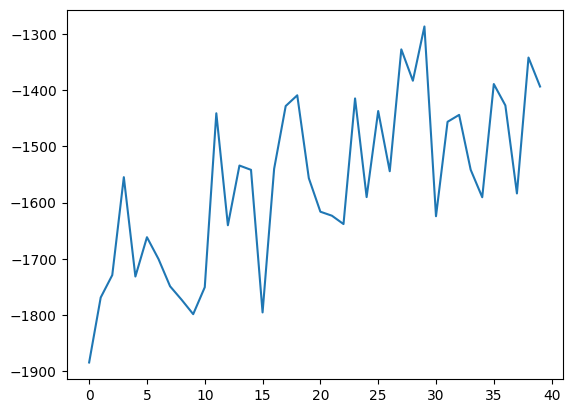

  4%|▍         | 16791/400000 [02:14<45:32, 140.24it/s]


Mean return value of last 8 evaluations = -1086.4412841796875


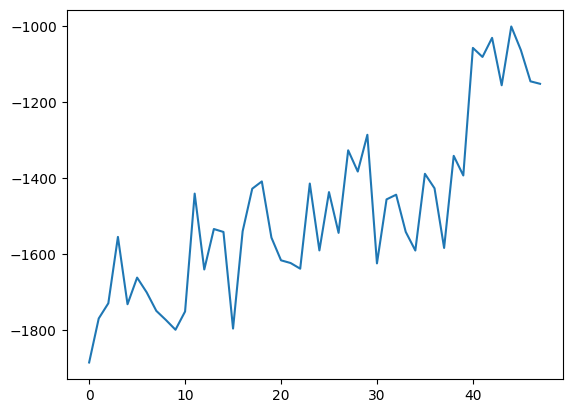

  5%|▍         | 19604/400000 [02:37<47:37, 133.14it/s]


Mean return value of last 8 evaluations = -1135.899658203125


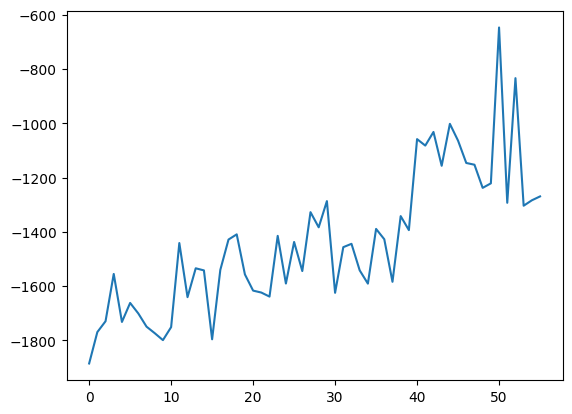

  6%|▌         | 22399/400000 [02:59<47:42, 131.92it/s]


Mean return value of last 8 evaluations = -850.452392578125


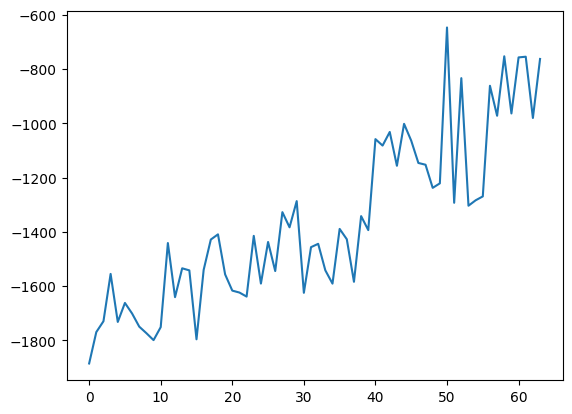

  6%|▋         | 25197/400000 [03:22<45:55, 136.03it/s]


Mean return value of last 8 evaluations = -1193.470703125


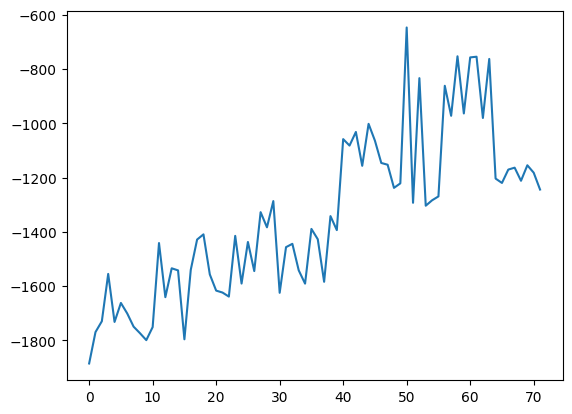

  7%|▋         | 28007/400000 [03:45<45:45, 135.51it/s]


Mean return value of last 8 evaluations = -904.3869018554688


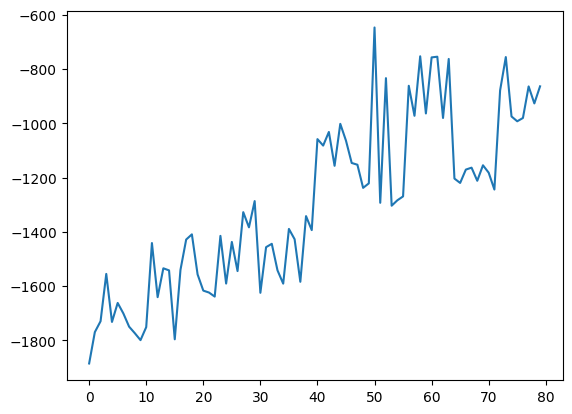

  8%|▊         | 30796/400000 [04:08<47:08, 130.52it/s]


Mean return value of last 8 evaluations = -966.8570556640625


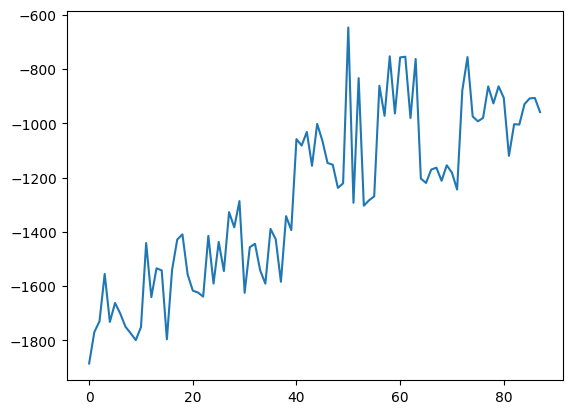

  8%|▊         | 33607/400000 [04:32<1:09:08, 88.31it/s]


Mean return value of last 8 evaluations = -936.8096923828125


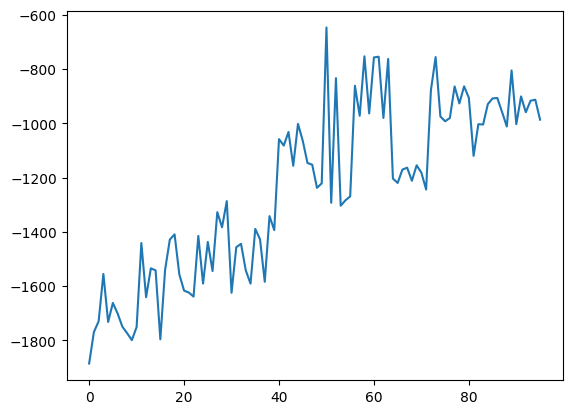

  9%|▉         | 36409/400000 [04:54<57:03, 106.19it/s]


Mean return value of last 8 evaluations = -689.572021484375


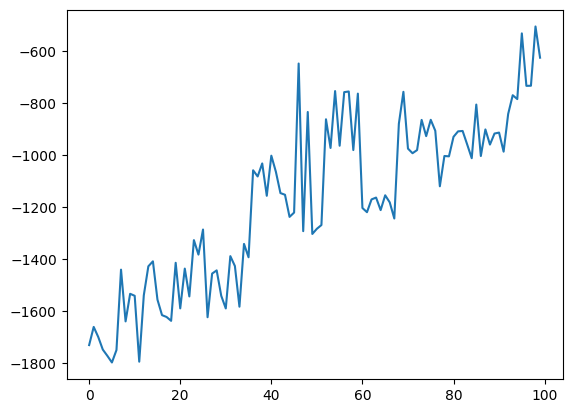

 10%|▉         | 39204/400000 [05:18<55:27, 108.42it/s]


Mean return value of last 8 evaluations = -797.6273193359375


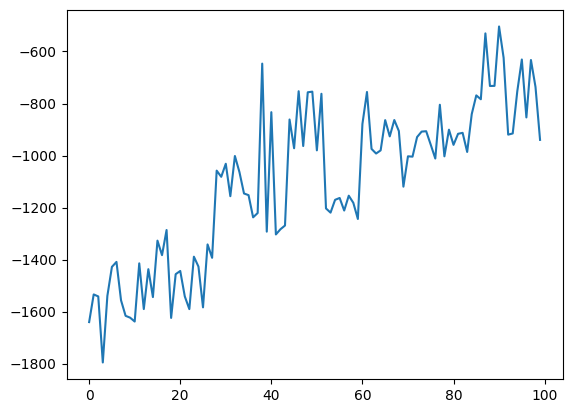

 11%|█         | 42010/400000 [05:41<47:38, 125.23it/s]


Mean return value of last 8 evaluations = -739.62890625


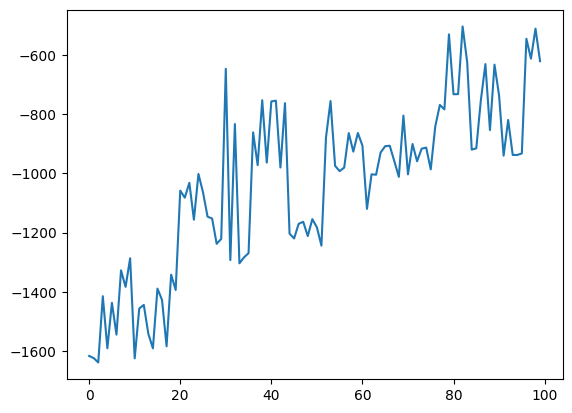

 11%|█         | 44811/400000 [06:04<43:26, 136.26it/s]


Mean return value of last 8 evaluations = -1173.9283447265625


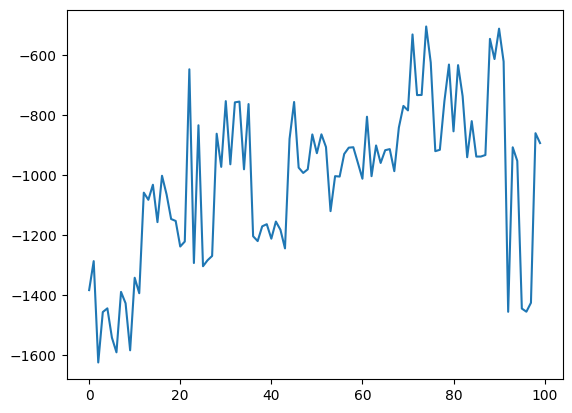

 12%|█▏        | 47607/400000 [06:28<48:14, 121.74it/s]


Mean return value of last 8 evaluations = -1183.677490234375


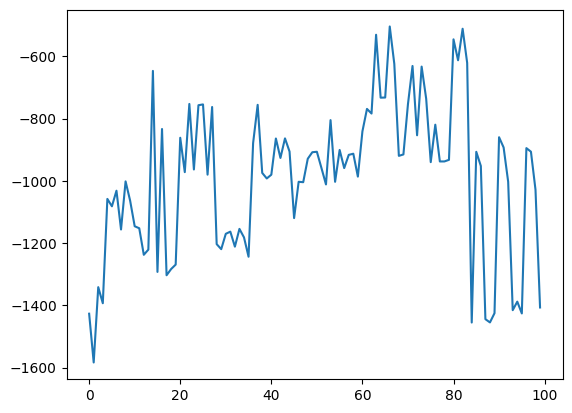

 13%|█▎        | 50410/400000 [06:52<42:08, 138.23it/s]


Mean return value of last 8 evaluations = -1144.8424072265625


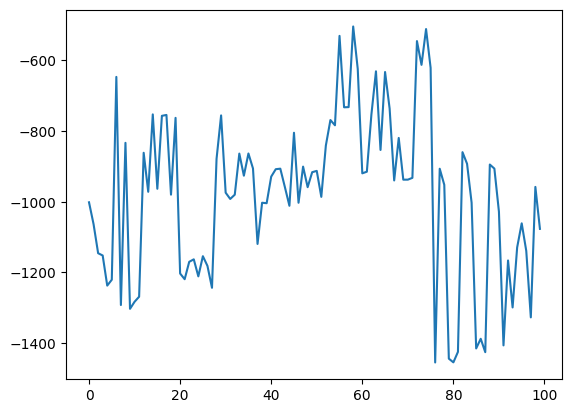

 13%|█▎        | 53210/400000 [07:16<46:30, 124.28it/s]


Mean return value of last 8 evaluations = -1306.925537109375


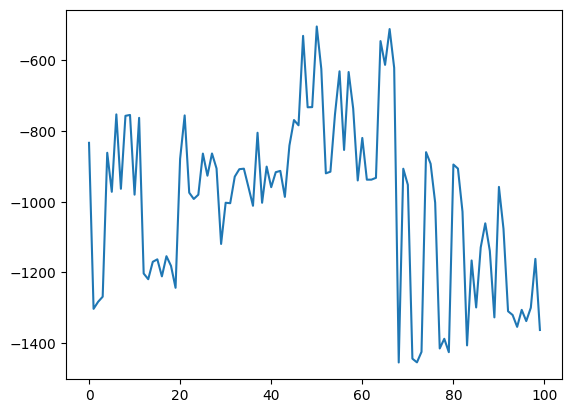

 14%|█▍        | 56011/400000 [07:40<50:55, 112.59it/s]


Mean return value of last 8 evaluations = -1299.57373046875


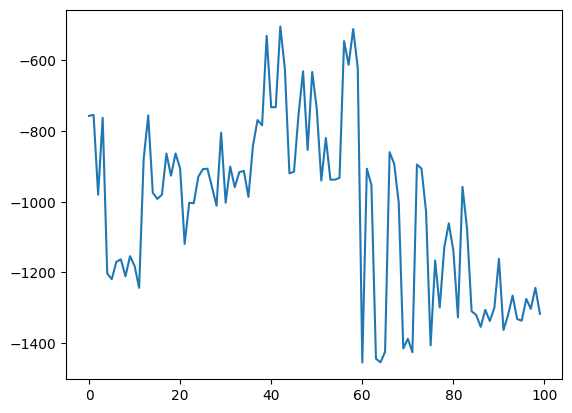

 15%|█▍        | 58813/400000 [08:05<1:02:35, 90.85it/s]


Mean return value of last 8 evaluations = -1174.75634765625


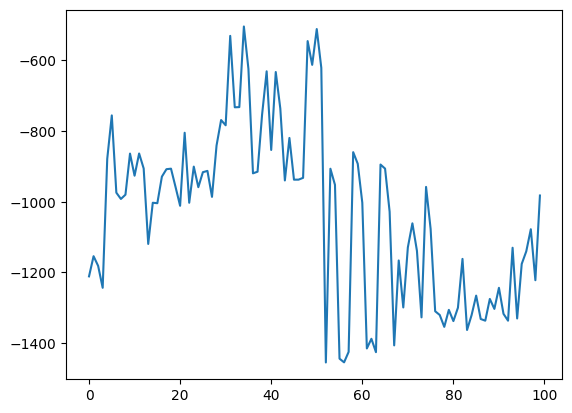

 15%|█▌        | 61615/400000 [08:31<48:06, 117.22it/s]


Mean return value of last 8 evaluations = -885.9818725585938


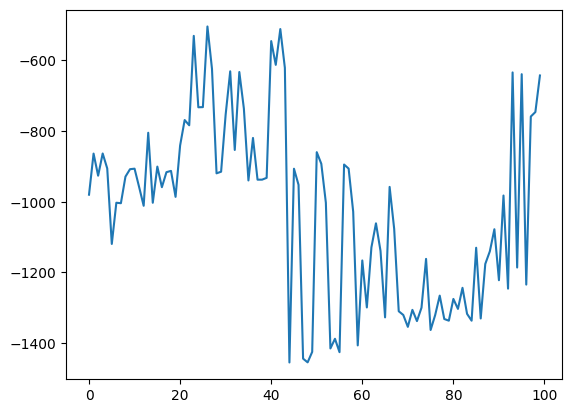

 16%|█▌        | 64417/400000 [08:58<51:10, 109.30it/s]


Mean return value of last 8 evaluations = -903.857177734375


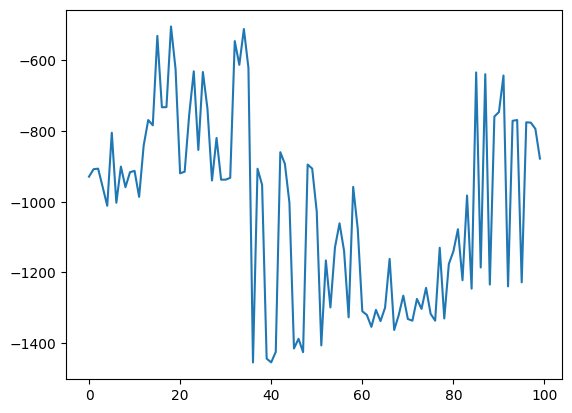

 17%|█▋        | 67219/400000 [09:26<52:04, 106.52it/s]


Mean return value of last 8 evaluations = -1071.641357421875


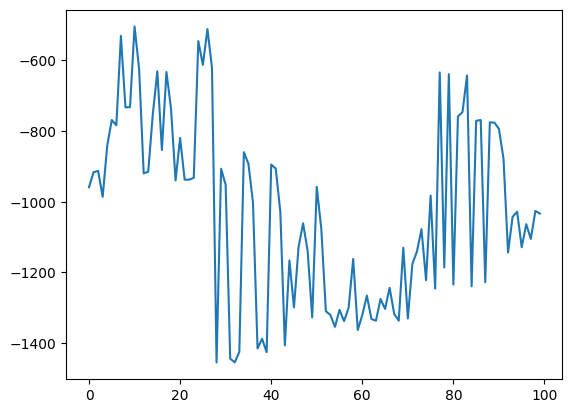

 18%|█▊        | 70020/400000 [09:55<54:01, 101.79it/s]


Mean return value of last 8 evaluations = -1076.0189208984375


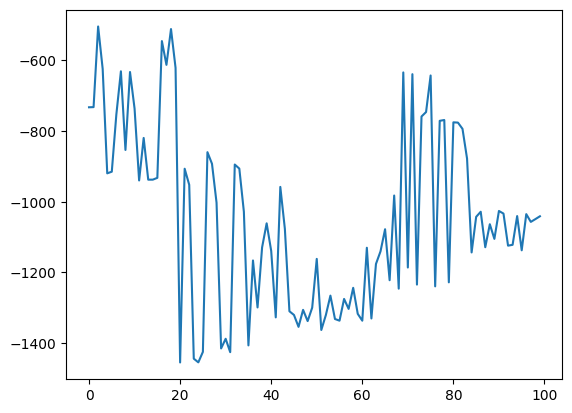

 18%|█▊        | 72819/400000 [10:26<55:38, 98.01it/s] 


Mean return value of last 8 evaluations = -1202.14501953125


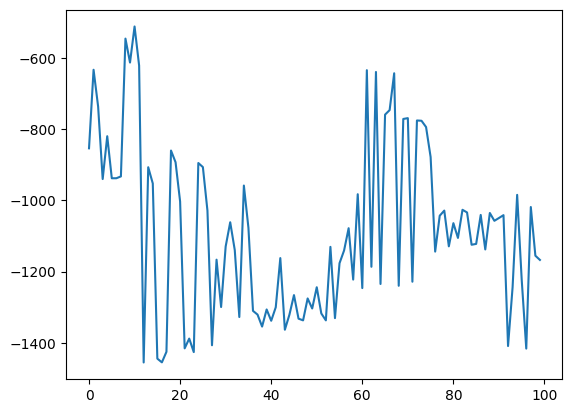

 19%|█▉        | 75617/400000 [10:57<56:06, 96.35it/s]


Mean return value of last 8 evaluations = -1364.60009765625


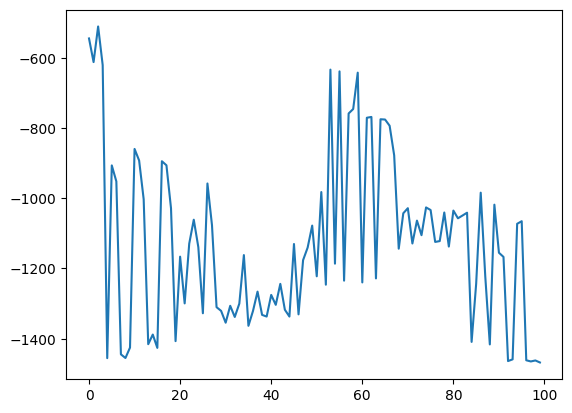

 20%|█▉        | 78424/400000 [11:30<59:53, 89.49it/s]


Mean return value of last 8 evaluations = -1082.9002685546875


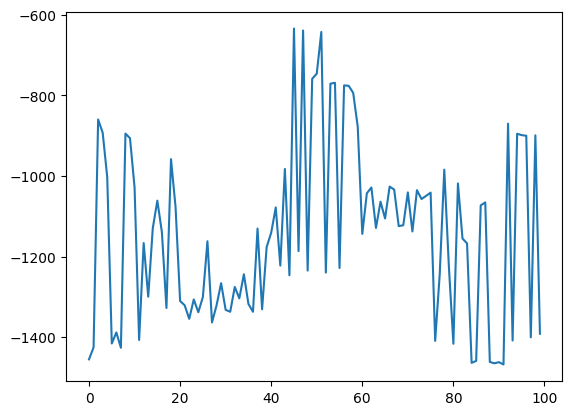

 20%|██        | 81222/400000 [12:02<56:31, 94.00it/s]


Mean return value of last 8 evaluations = -905.8321533203125


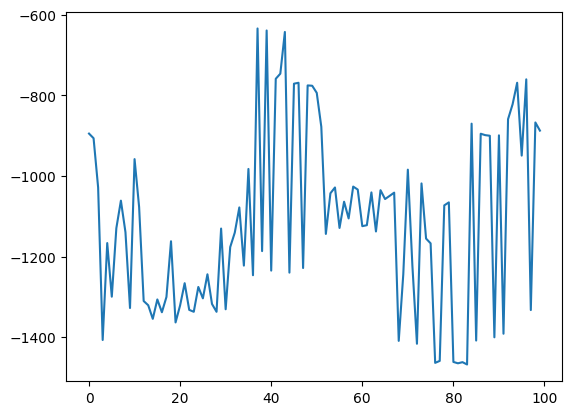

 21%|██        | 84027/400000 [12:36<54:45, 96.17it/s]


Mean return value of last 8 evaluations = -819.4881591796875


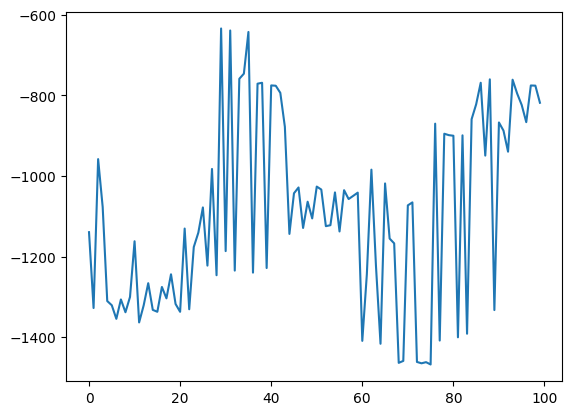

 22%|██▏       | 86822/400000 [13:09<58:04, 89.89it/s]


Mean return value of last 8 evaluations = -978.3865966796875


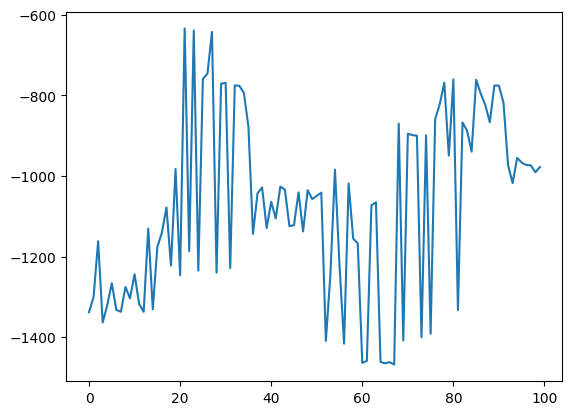

 22%|██▏       | 89628/400000 [13:42<56:37, 91.35it/s]


Mean return value of last 8 evaluations = -1074.939208984375


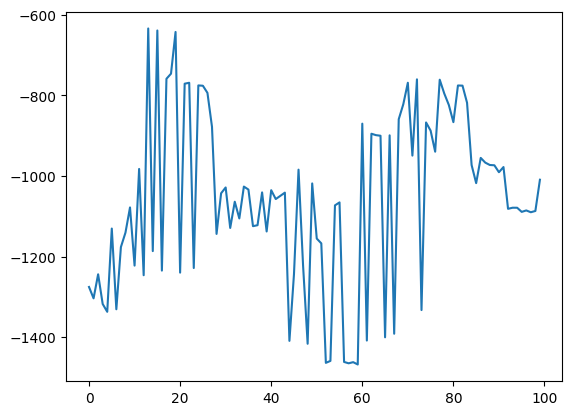

 23%|██▎       | 92427/400000 [14:15<1:09:45, 73.49it/s]


Mean return value of last 8 evaluations = -904.8496704101562


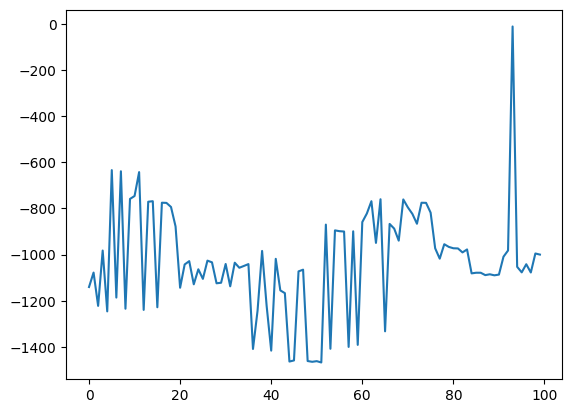

 24%|██▍       | 95223/400000 [14:49<59:50, 84.89it/s]


Mean return value of last 8 evaluations = -1051.9892578125


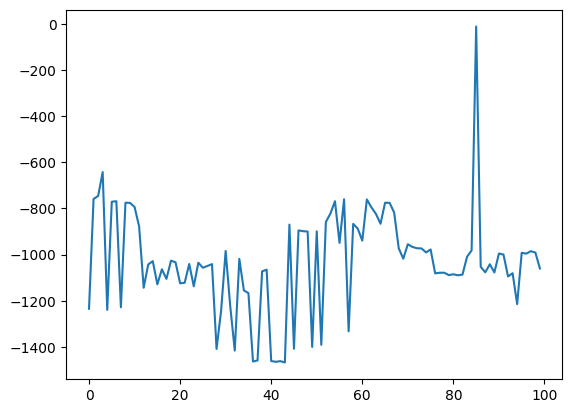

 25%|██▍       | 98030/400000 [15:23<58:47, 85.61it/s]


Mean return value of last 8 evaluations = -1258.2080078125


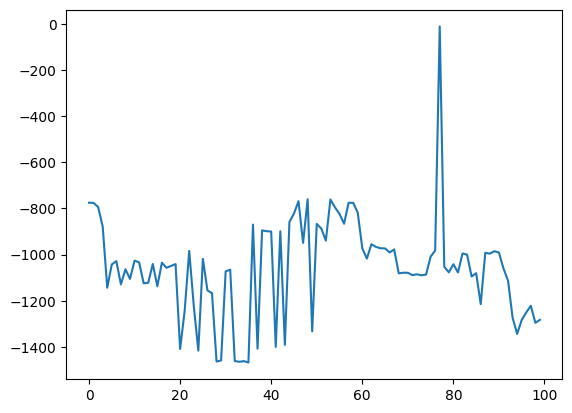

 25%|██▌       | 100825/400000 [15:59<54:55, 90.78it/s]


Mean return value of last 8 evaluations = -1151.7449951171875


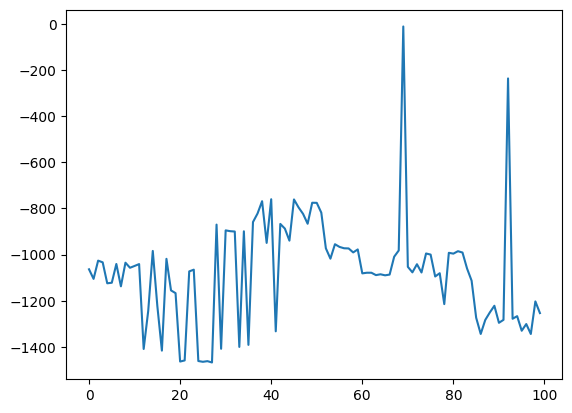

 26%|██▌       | 103629/400000 [16:34<58:07, 84.98it/s]


Mean return value of last 8 evaluations = -978.8746337890625


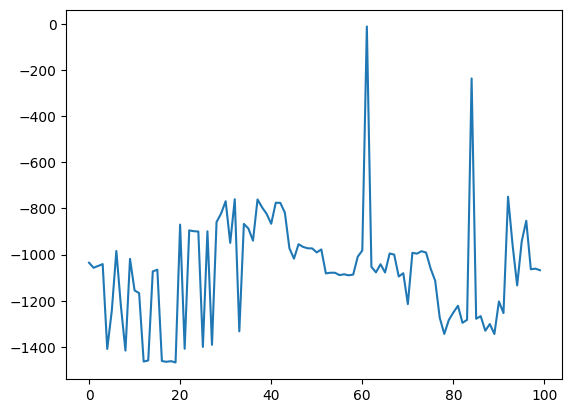

 27%|██▋       | 106434/400000 [17:09<55:07, 88.76it/s]


Mean return value of last 8 evaluations = -951.2705688476562


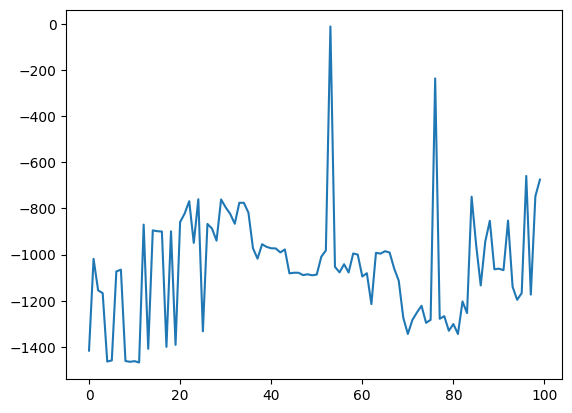

 27%|██▋       | 109231/400000 [17:45<1:00:10, 80.53it/s]


Mean return value of last 8 evaluations = -675.7955932617188


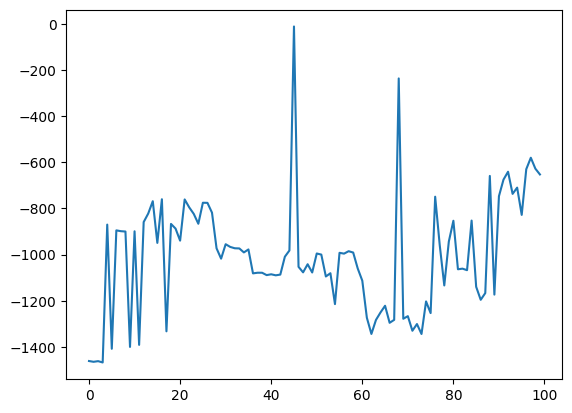

 28%|██▊       | 112030/400000 [18:20<56:22, 85.14it/s]


Mean return value of last 8 evaluations = -206.88204956054688


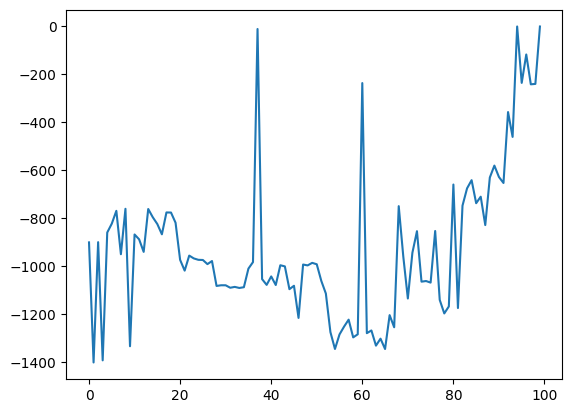

 28%|██▊       | 112038/400000 [18:21<47:11, 101.69it/s]


In [29]:
ENV = "Pendulum-v1"
env = gym.make(ENV)

GAMMA = 0.99
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
HIDDEN_DIMS = ((256, 128, 64), (256, 128, 64))
TAU = 2e-3
UPDATE_EVERY = 1
LR = (1e-3, 1e-3)
DECAY_STEPS = int(5e4)


agent = DDPG(env, GAMMA, BUFFER_SIZE, BATCH_SIZE, HIDDEN_DIMS, optim.Adam, optim.Adam, TAU, UPDATE_EVERY, DECAY_STEPS, LR)

TIME_STAMPS = int(4e5)
STEP = 15
EVAL = 8
GOAL = -250
agent.train(TIME_STAMPS, STEP, EVAL, GOAL)
agent.env.close()